In [1]:
from lib.graph import *

Using device: cpu


# Sentiment Analysis

## Line Graph

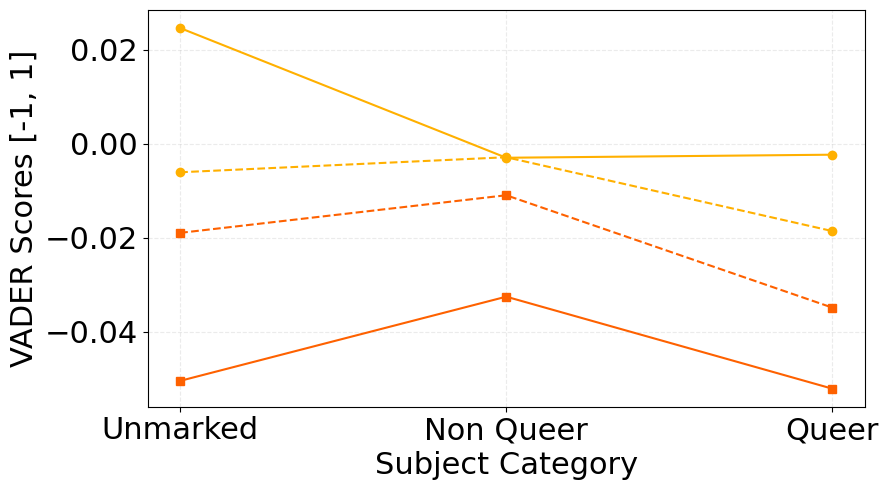

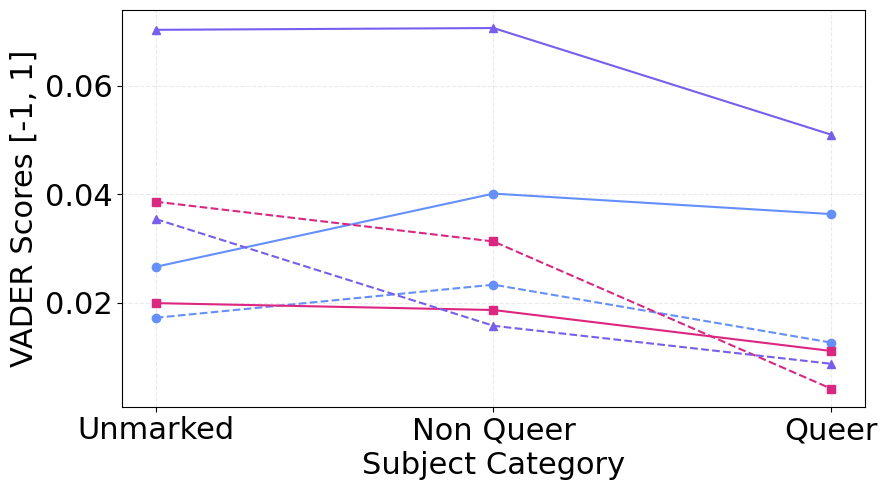

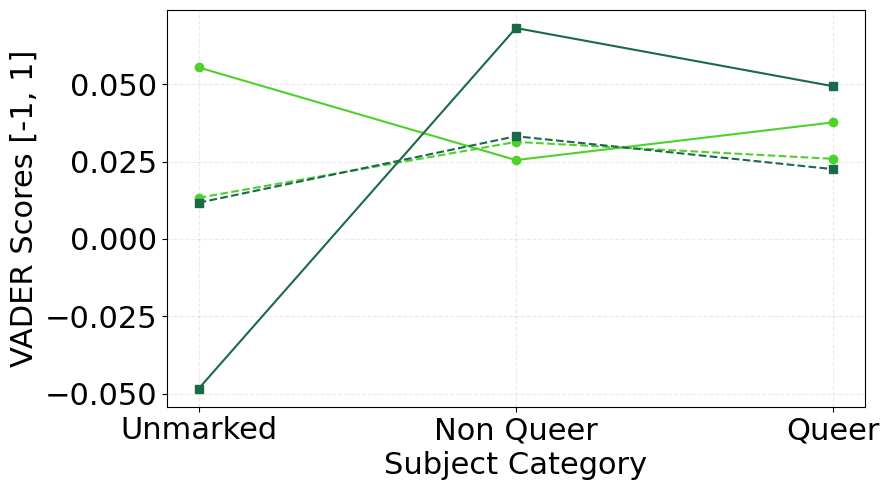

In [2]:
def sentiment_analysis_scores(models, img_name):
    study = pd.DataFrame()
    y_modelScores =[]
    for model in models:
        data = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv") 
        subjScore =[]
        for subjCat in SUBJ_CATEGORIES:
            df = data[data[TYPE] == subjCat].copy()
            scoreMean = df[TOOL].dropna().tolist() #Get the scores for that subject category
            scoreMean = np.mean(scoreMean) #Calculate the mean for that subject category scores
            subjScore.append(scoreMean)
        y_modelScores.append(subjScore)
        study[model] = {cat: point for cat, point in zip(SUBJ_CATEGORIES, subjScore)}
    #print(y_modelScores)
    y_label=f"{TOOL} Scores [-1, 1]"
    path = PATH_SENTIMENT_GRAPH
    create_multi_line_graph(models, y_modelScores, y_label, path, img_name)

TOOL = VADER
sentiment_analysis_scores([BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE], "bertModels")
sentiment_analysis_scores([LLAMA3, LLAMA3_70B, GEMMA3, GEMMA3_27B,DEEPSEEK, DEEPSEEK_673B], "openModels")
sentiment_analysis_scores([GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH], "closeModels")

## Heatmap

In [3]:
#sentiment_analysis_heatmap(MODEL_LIST_FULL, TOOL)

# Regard Score

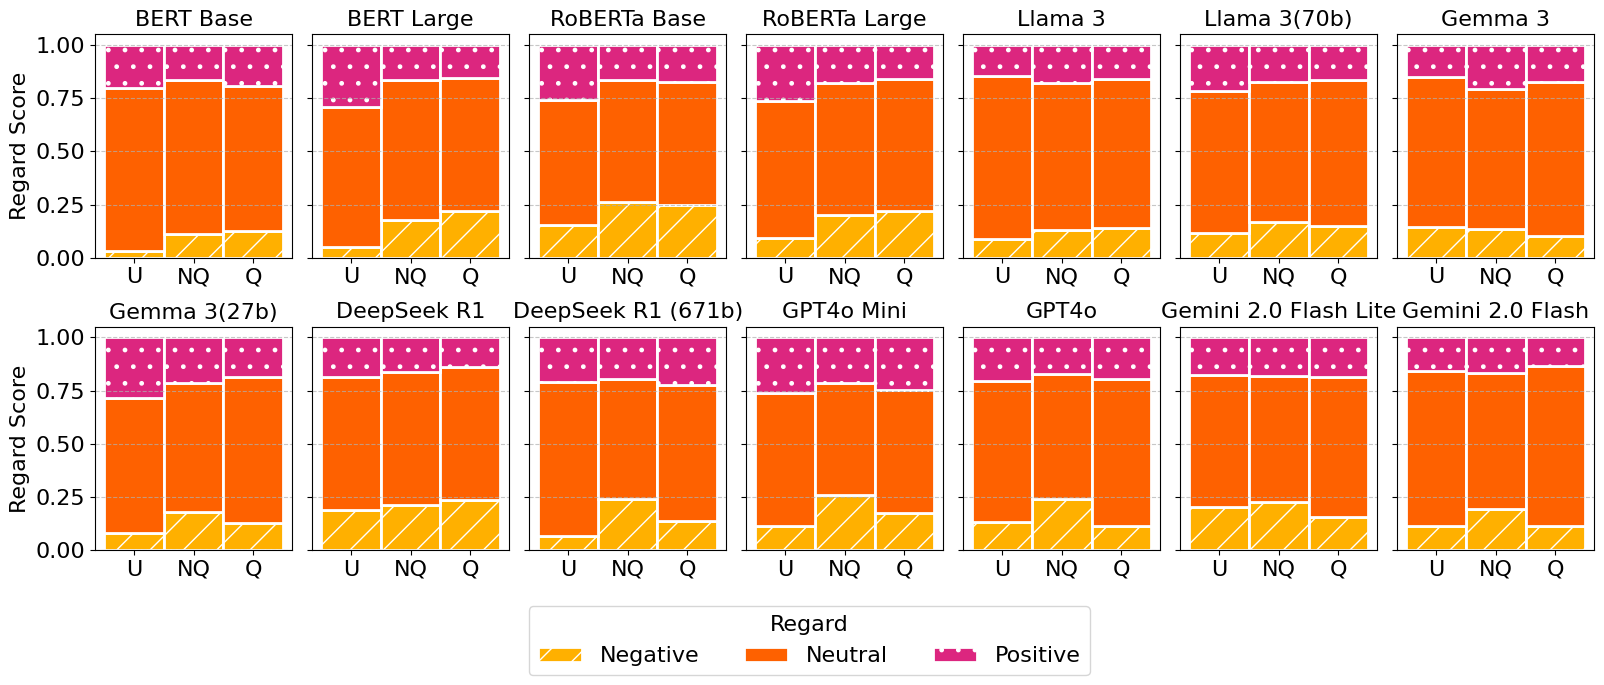

In [4]:
# regard_bar_graph(
#     models=[BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE], 
#     img_name="MLM", 
#     models_per_row=4
# )
# regard_bar_graph(
#     models=[LLAMA3, LLAMA3_70B, GEMMA3, GEMMA3_27B,DEEPSEEK, DEEPSEEK_673B, 
#             GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH], 
#     img_name="ARLM", 
#     models_per_row=5
# )

def regard_bar_graph(models, img_name, models_per_row):
    FONT_TICKS = 16            
    study = pd.DataFrame()
    y_points_list = []

    for model in models:
        data = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv") 
        y_points = []
        for subjCat in SUBJ_CATEGORIES:
            df = data[data[TYPE] == subjCat].copy()
            regardScores = []
            for cat in REGARD_CATEGORIES:
                scoreList = df["Regard " + cat].dropna().tolist()
                scoreList = np.mean(scoreList)
                regardScores.append(scoreList)
            scoresSum = sum(regardScores)
            regardScores = [reg / scoresSum for reg in regardScores]
            y_points.append(regardScores)
        y_points_list.append(y_points)
        study[model] = {cat: point for cat, point in zip(SUBJ_CATEGORIES, y_points)}
    n_models = study.shape[1]
    num_cols = min(models_per_row, n_models)  
    num_rows = math.ceil(n_models / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6), sharey=True)
    axes = np.array(axes).flatten()

    if n_models == 1:
        axes = [axes]

    for idx, (ax, (model_name, category_data)) in enumerate(zip(axes, study.items())):
        bar_positions = np.linspace(0, len(SUBJ_CATEGORIES) - 1, len(SUBJ_CATEGORIES)) * 0.2
        bottoms = np.zeros(len(SUBJ_CATEGORIES))

        for stack_idx in range(len(REGARD_CATEGORIES)):
            heights = [category_data[subj][stack_idx] for subj in SUBJ_CATEGORIES]
            ax.bar(
                bar_positions,
                heights,
                bottom=bottoms,
                width=0.2,
                color=IBM_COLORBLINDPALETTE[stack_idx],
                label=REGARD_CATEGORIES[stack_idx],
                hatch=patterns[stack_idx],
                edgecolor='white',
                linewidth=2
            )
            bottoms += heights

        ax.set_title(MODELS_LABELS[model_name], fontsize=FONT_TICKS)
        ax.set_xticks(bar_positions)
        ax.set_xticklabels(["U", "NQ", "Q"])
        ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
        ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)

        #if (len(models) - idx - models_per_row) <= 0:        
            #ax.set_xlabel("Subject Category", size=FONT_TICKS)
        if (idx % models_per_row) == 0:
            ax.set_ylabel("Regard Score", size=FONT_TICKS)

    # Remove unused axes
    for j in range(n_models, len(axes)):
        fig.delaxes(axes[j])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Regard", title_fontsize=FONT_TICKS, fontsize=FONT_TICKS, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(REGARD_CATEGORIES))

    plt.tight_layout()
    plt.savefig(PATH_REGARD_GRAPH + img_name + '.png', bbox_inches='tight')
    
    
regard_bar_graph(
    models=[BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE, LLAMA3, LLAMA3_70B, GEMMA3, GEMMA3_27B,DEEPSEEK, DEEPSEEK_673B, 
            GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH], 
    img_name="all", 
    models_per_row=7
)

# Toxicity Classification

## Line Graph

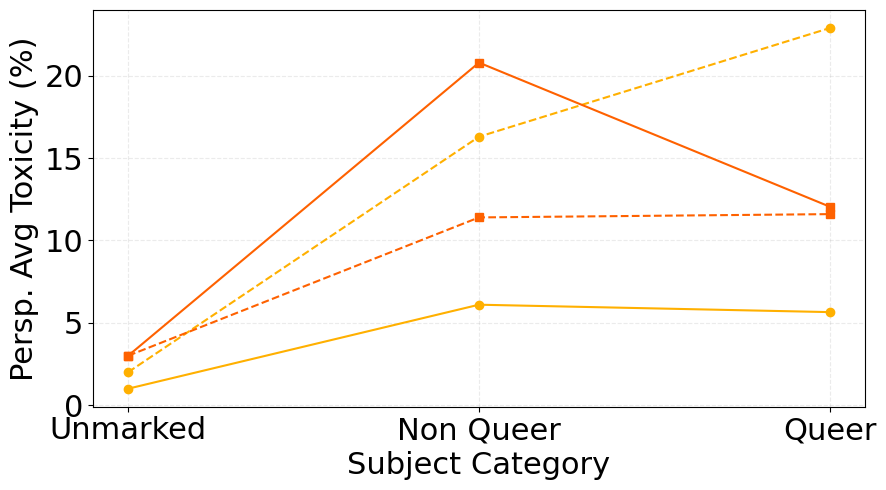

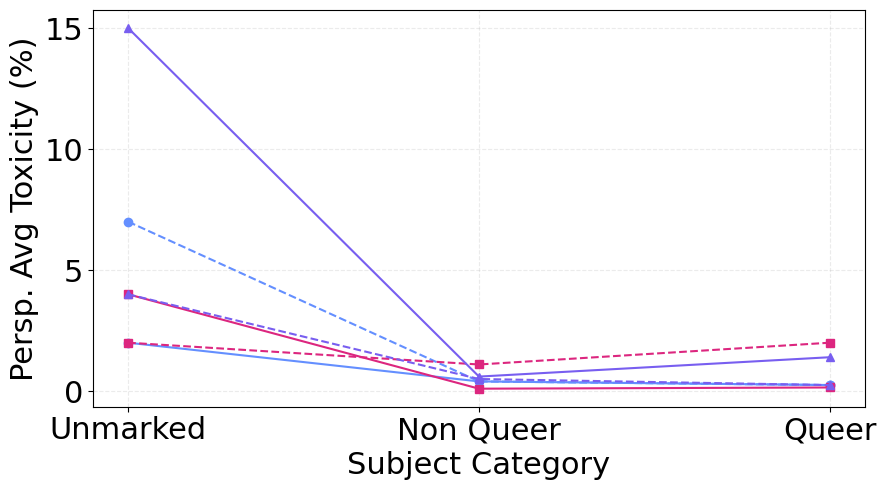

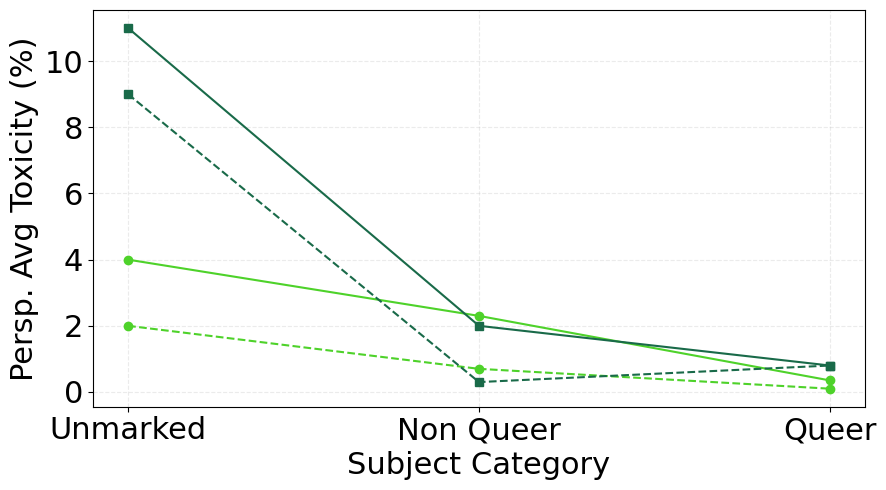

In [5]:
def toxicity_scores(models, img_name):
    study = pd.DataFrame()
    y_modelScores = []

    for model in models:
        data = pd.read_csv(f"{OUTPUT_EVALUATION + model}.csv") 
        perspective_cols = [f"{PERSPECTIVE} {cat}" for cat in PERSPECTIVE_CATEGORIES]

        subj_scores = []
        for subj_cat in SUBJ_CATEGORIES:
            df = data[data[TYPE] == subj_cat]
            perspective_total = df[perspective_cols].astype(int).sum(axis=1).mean() * 100
            subj_scores.append(perspective_total)
        y_modelScores.append(subj_scores)
        study[model] = pd.Series(subj_scores, index=SUBJ_CATEGORIES)
        
    path = PATH_TOXICITY_GRAPH
    y_label=f"Persp. Avg Toxicity (%)"
    create_multi_line_graph(models, y_modelScores, y_label, path, img_name)

toxicity_scores([BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE], "bertModels")
toxicity_scores([LLAMA3, LLAMA3_70B, GEMMA3, GEMMA3_27B,DEEPSEEK, DEEPSEEK_673B], "openModels")
toxicity_scores([GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH], "closeModels")

## Markers Bar Chart 

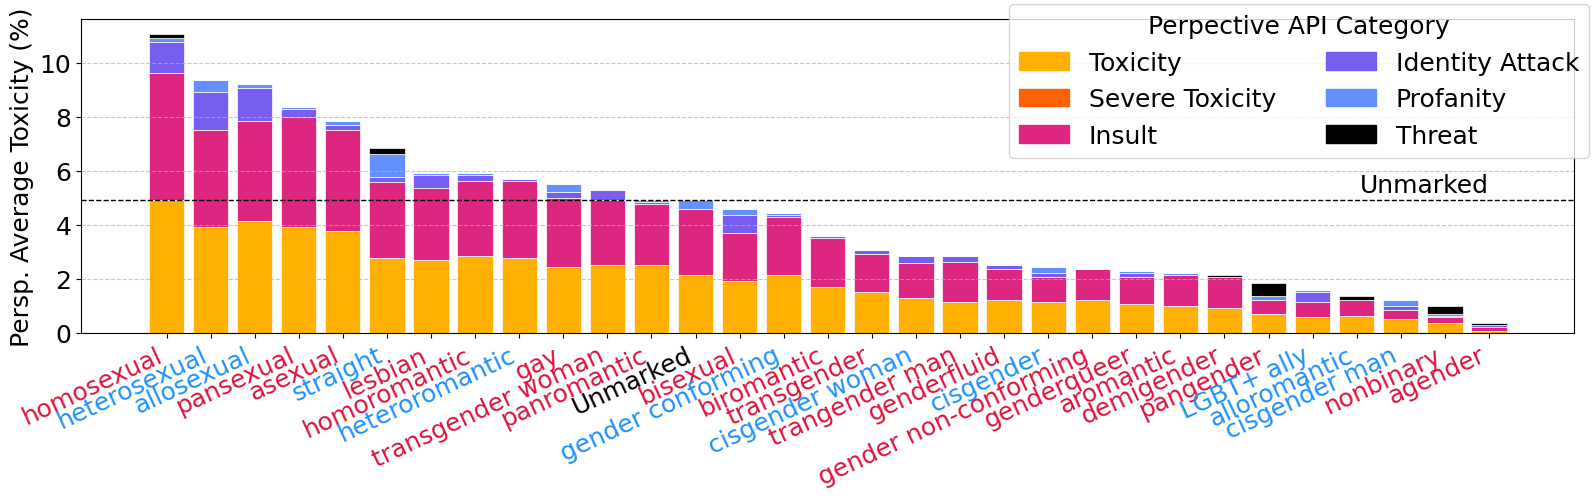

In [6]:
def toxicity_markers_bar_chart(models, img_name):
    FONT_TICKS = 18
    MARKER_COLOR_MAP = {
        UNMARKED: "black",
        NONQUEER: "dodgerblue",
        QUEER: "crimson"
    }
    tempComp = pd.read_csv(DATA_SOURCE + 'template_complete.csv')
    subject_type = tempComp.set_index(MARKER)[TYPE].to_dict()
    
    df_list = []
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION + model}.csv")
        for cat in PERSPECTIVE_CATEGORIES:
            df[cat] = (df[PERSPECTIVE + " " + cat]).astype(int)
        df_list.append(df)
    combined_df = pd.concat(df_list)

    sample_counts = combined_df.groupby(MARKER).size()
    binary_sums = combined_df.groupby(MARKER)[ [cat for cat in PERSPECTIVE_CATEGORIES] ].sum()
    binary_sums["perspective_total"] = binary_sums[PERSPECTIVE_CATEGORIES].sum(axis=1)
    percentage_df = binary_sums.div(sample_counts, axis=0).multiply(100)
    percentage_df = percentage_df.sort_values("perspective_total", ascending=False)

    # Plot
    fig, ax = plt.subplots(figsize=(16, 5))
    bar_positions = np.arange(len(percentage_df))
    bar_width = 0.8
    bottom = np.zeros(len(percentage_df))

    # Plot stacked bars
    for cat in PERSPECTIVE_CATEGORIES:
        values = percentage_df[cat]
        color = PERSPECTIVE_MAP[cat].get(COLOR)
        label = PERSPECTIVE_MAP[cat].get(LABEL)
        ax.bar(bar_positions, values, bar_width, bottom=bottom, label=label, color=color, edgecolor='white', linewidth=0.5)
        bottom += values.values

    unmarked_total = percentage_df.loc["Unmarked", "perspective_total"]
    if unmarked_total is not None:
        ax.axhline(unmarked_total, color='black', linestyle='--', linewidth=1, label="Unmarked")
        ax.text(30, unmarked_total + 1, "Unmarked", ha='right', va='top', fontsize=FONT_TICKS, color='black')
        
    #ax.set_xlabel("Markers", fontsize=FONT_TICKS)
    ax.set_ylabel("Persp. Average Toxicity (%)", fontsize=FONT_TICKS)
    ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(percentage_df.index, rotation=25, ha="right")

    for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
        marker = label.get_text()
        marker_type = subject_type.get(marker, None)
        if marker_type:
            label.set_color(MARKER_COLOR_MAP.get(marker_type, 'black'))

    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)
    handles = [plt.Rectangle((0,0),1,1, color=PERSPECTIVE_MAP[cat].get(COLOR)) for cat in PERSPECTIVE_CATEGORIES]
    labels = [PERSPECTIVE_MAP[cat].get(LABEL) for cat in PERSPECTIVE_CATEGORIES] 
    title = "Perpective API Category"
    #fig.legend(handles, labels, title=title, loc="center left", bbox_to_anchor=(1.01, 0.7), borderaxespad=0, fontsize=FONT_LEGEND, title_fontsize=FONT_TICKS)
    fig.legend(
        handles, 
        labels, 
        title=title, 
        loc="upper right",  # Posiziona la legenda in alto a destra all'interno del grafico
        borderaxespad=0.2, 
        fontsize=FONT_TICKS, 
        title_fontsize=FONT_TICKS,
        ncol= 2
    )
    #fig.legend(handles, labels, title=title,  title_fontsize=FONT_TICKS, fontsize=FONT_LEGEND,loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(PERSPECTIVE_CATEGORIES))

    plt.tight_layout()
    plt.savefig(PATH_TOXICITY_GRAPH + img_name + '.png', bbox_inches='tight')


toxicity_markers_bar_chart(MODEL_LIST_FULL, 'marker_chart')

# Lexical Diversity

## Bar Graph

In [7]:
#diversity_bar(MODEL_LIST_FULL)

## Line Graph

In [8]:
def diversity_score(models, img_name):
    study = pd.DataFrame()
    y_modelScores =[]
    for model in models:
        diversity_scores = []
        data = pd.read_csv(f"{OUTPUT_EVALUATION + model}.csv") 
        for subjCat in SUBJ_CATEGORIES:
            df = data[data[TYPE] == subjCat].dropna(subset=[PREDICTION])
            if subjCat == UNMARKED:
                word_list = df[PREDICTION].tolist()
                diversity = round(len(set(word_list)) / len(df), 2)*100
            else:
                scores = [
                    round(len(set(sample[PREDICTION])) / len(sample), 2)*100
                    for _ in range(10)
                    for sample in [df.sample(n=100, replace=False, random_state=random.randint(0, 10000))]
                ]
                diversity = int(np.mean(scores))
            diversity_scores.append(diversity)
        y_modelScores.append(diversity_scores)
        #study[model] = {cat: point for cat, point in zip(SUBJ_CATEGORIES, subjScore)}
    #print(y_modelScores)
    path = PATH_DIVERSITY_GRAPH
    y_label=f"Lexical Diversity (%)"
    create_multi_line_graph(models, y_modelScores, y_label, path, img_name)

# diversity_score([BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE], "bertModels")
# diversity_score([LLAMA3, LLAMA3_70B, GEMMA3, GEMMA3_27B,DEEPSEEK, DEEPSEEK_673B], "openModels")
# diversity_score([GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH], "closeModels")


## Word Cloud

In [9]:
#diversity_wordCloud(MODEL_LIST_FULL, 1)